# 以（Regularized Least Square）为学习算法，对比线性方法，核方法，nys方法的时间和精度

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from   sklearn.gaussian_process.kernels import RBF
from   sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import time
import numpy as np
from   sklearn.exceptions import NotFittedError
from   sklearn.linear_model import Ridge
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem
import numpy as np 

In [10]:

class RFFRidgeRegression:

    def __init__(self, rff_dim=1, alpha=1.0, sigma=1.0):
        """Kernel ridge regression using random Fourier features.

        rff_dim : Dimension of random feature.
        alpha :   Regularization strength. Should be a positive float.
        """
        self.fitted  = False
        self.rff_dim = rff_dim
        self.sigma   = sigma
        self.lm      = Ridge(alpha=alpha)
        self.b_      = None
        self.W_      = None

    def fit(self, X, y):
        """Fit model with training data X and target y.
        """
        Z, W, b = self._get_rffs(X, return_vars=True)
        self.lm.fit(Z.T, y)
        self.b_ = b 
        self.W_ = W
        self.fitted = True
        return self

    def predict(self, X):
        """Predict using fitted model and testing data X.
        """
        if not self.fitted:
            msg = "Call 'fit' with appropriate arguments first."
            raise NotFittedError(msg)
        Z = self._get_rffs(X, return_vars=False)
        return self.lm.predict(Z.T)

    def _get_rffs(self, X, return_vars):
        """Return random Fourier features based on data X, as well as random
        variables W and b.
        """
        N, D = X.shape
        if self.W_ is not None:
            W, b = self.W_, self.b_ #在训练后保存
        else:
            W = np.random.normal(loc=0, scale=1, size=(self.rff_dim, D))
            b = np.random.uniform(0, 2*np.pi, size=self.rff_dim)

        B    = np.repeat(b[:, np.newaxis], N, axis=1)
        norm = 1./ np.sqrt(self.rff_dim)
        Z    = norm * np.sqrt(2) * np.cos(self.sigma * W @ X.T + B)

        if return_vars:
            return Z, W, b
        return Z


In [35]:

class NystromRidgeRegression:

    def __init__(self, gamma=.2,rff_dim=1,  random_state=1, alpha=1.0,  n_components=7):
        """Kernel ridge regression using Nystrom features.

        rff_dim : Dimension of random feature.
        alpha :   Regularization strength. Should be a positive float.
        """
        self.fitted  = False
        self.n_components = n_components
        self.gamma   = gamma
        self.lm      = Ridge(alpha=alpha)
        self.b_      = None
        self.W_      = None

    def fit(self, X, y):
        """Fit model with training data X and target y.
        """
         
        #Z, W, b = self._get_rffs(X, return_vars=True)
        Z = self._get_rffs(X, return_vars=True)
        
        self.lm.fit(Z , y)
          
#         self.b_ = b 
#         self.W_ = W
        self.fitted = True
        return self

    def predict(self, X):
        """Predict using fitted model and testing data X.
        """
        if not self.fitted:
            msg = "Call 'fit' with appropriate arguments first."
            raise NotFittedError(msg)
        Z = self._get_rffs(X, return_vars=False)
        return self.lm.predict(Z)

    def _get_rffs(self, X, return_vars):
        """Return Nys features based on data X
        """
        feature_map_nystroem = Nystroem(gamma=self.gamma,
                                random_state=1,
                                n_components=self.n_components)
        data_transformed = feature_map_nystroem.fit_transform(X)
         
        Z= data_transformed 
        print(Z.shape )
          
#         if return_vars:
#             return Z, W, b
        return Z


In [38]:
# clf     = NystromRidgeRegression ( n_components=rff_dim)
# start = time.time()
# clf    = clf.fit(X, y)
# clf.predict(X)

# 定义数据

In [8]:
N     = 500 
X     = np.linspace(-10, 10, N)[:, None]
mean  = np.zeros(N)
cov   = RBF()(X.reshape(N, -1))
y     = np.random.multivariate_normal(mean, cov)
noise = np.random.normal(0, 0.5, N)
y    += noise

# Finer resolution for smoother curve visualization.
X_test = np.linspace(-10, 10, N*2)[:, None]
mean  = np.zeros(N*2)
cov   = RBF()(X_test.reshape(N*2, -1))
y_test  = np.random.multivariate_normal(mean, cov)
noise = np.random.normal(0, 0.5, N*2)
y_test    += noise

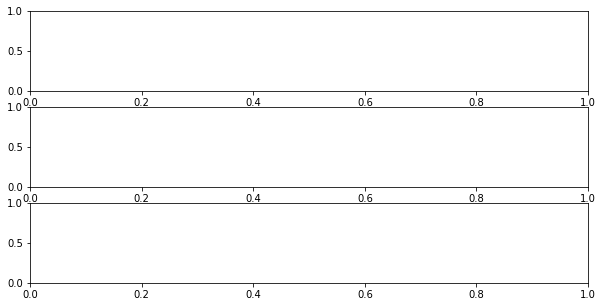

In [4]:
# Set up figure and plot data.
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(10, 5)
 


Linear Training time: 0.006066322326660156s
Linear Testing time: 0.001734018325805664s
回归metric： 0.8644732914769855

RBF Training time: 0.0059757232666015625s
RBF Testing time: 0.004144191741943359s
回归metric： 2.047923803983845

(500, 20)
Nystrom training time: 0.0023169517517089844s
(1000, 20)
Nystrom Testing time: 0.0022590160369873047s
回归metric： 1.6155425401469907



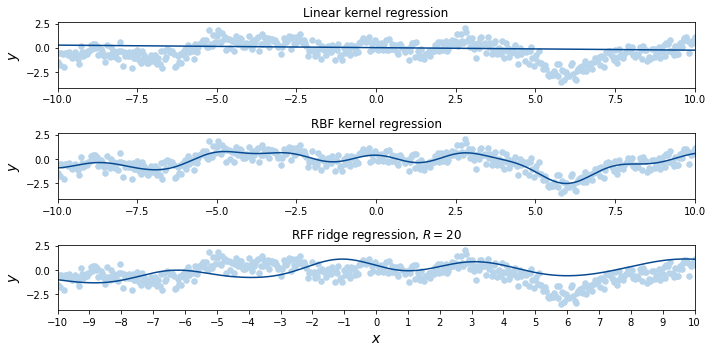

In [39]:
# Set up figure and plot data.
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(10, 5)
ax3, ax1, ax2    = axes
cmap      = plt.cm.get_cmap('Blues')

ax3.scatter(X, y, s=30, c=[cmap(0.3)])
ax1.scatter(X, y, s=30, c=[cmap(0.3)])
ax2.scatter(X, y, s=30, c=[cmap(0.3)])

# Fit  ridege regression using an linear kernel.
clf    = KernelRidge(kernel="linear")
start = time.time()
clf    = clf.fit(X, y)
stop = time.time()
print(f"Linear Training time: {stop - start}s")
start = time.time()
y_pred = clf.predict(X_test)
stop = time.time()
print(f"Linear Testing time: {stop - start}s")
 
ax3.plot(X_test, y_pred, c=cmap(0.9) )

#print ( y_pred.shape, y_test.shape )
 
print ("回归metric：", mean_squared_error(y_test, y_pred))
print ( )

# Fit kernel ridege regression using an RBF kernel.
clf    = KernelRidge(kernel=RBF())
start = time.time()
clf    = clf.fit(X, y)
stop = time.time()
print(f"RBF Training time: {stop - start}s")
start = time.time()
y_pred = clf.predict(X_test)
stop = time.time()
print(f"RBF Testing time: {stop - start}s")
ax1.plot(X_test, y_pred, c=cmap(0.9))
print ("回归metric：", mean_squared_error(y_test, y_pred))
print ( )

# Fit kernel ridge regression using random Fourier features.
rff_dim = 20
# clf     = RFFRidgeRegression(rff_dim=rff_dim)
clf     = NystromRidgeRegression ( n_components=rff_dim)
start = time.time()
clf    = clf.fit(X, y)
stop = time.time()
print(f"Nystrom training time: {stop - start}s")
start = time.time()
y_pred = clf.predict(X_test)
stop = time.time()
print(f"Nystrom Testing time: {stop - start}s")
ax2.plot(X_test, y_pred, c=cmap(0.9))
print ("回归metric：", mean_squared_error(y_test, y_pred))
print ( )
# Labels, etc.
ax3.margins(0, 0.1)
ax3.set_title('Linear kernel regression')
ax3.set_ylabel(r'$y$', fontsize=14)
#ax3.set_xticks([])
ax2.set_xticks(np.arange(-10, 10.1, 1))


# Labels, etc.
ax1.margins(0, 0.1)
ax1.set_title('RBF kernel regression')
ax1.set_ylabel(r'$y$', fontsize=14)
ax2.set_xticks(np.arange(-10, 10.1, 1))

ax2.margins(0, 0.1)
ax2.set_title(rf'RFF ridge regression, $R = {rff_dim}$')
ax2.set_ylabel(r'$y$', fontsize=14)
ax2.set_xlabel(r'$x$', fontsize=14)
ax2.set_xticks(np.arange(-10, 10.1, 1))



plt.tight_layout()
plt.show()
